MNIST手写数据集是深度学习中的“Hello world”，是深度学习中最容易上手的一个项目。MNIST的任务是让计算机识别手写数据集。该数据集包含70,000张手写数字图像: 60,000张用于训练模型，10,000张用于测试。图像是灰度的，分辨率也仅有28x28像素，因而程序的预处理和运行都很方便。

在这个网络当中，我们将使用两个卷积层，一个池化层和两个全连接层，这些层将28x28的像素块压缩成9维的向量，并与正确的数字预测结果做比较。一般而言，深度学习的框架由四部分组成：网络结构、损失函数、数据集和优化器。在本次的介绍中，我们会把这四个模块分别解耦进行讲解。

首先我们先来导入相关库,运行本程序需要拥有pytorch和anaconda3的环境

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np


In [2]:
import gzip
import os
import matplotlib.pyplot as plt

In [3]:
n_epochs = 10
batch_size_train = 60
batch_size_test = 1000
lr = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

现在我们来开始尝试导入数据集，这一步的主要目的是将深度学习的图像转换成pytorch能够看懂的数据格式。我们先来创建一个dataset类，并用pytorch的`dataloader`方法加载mnist数据集。在下述的类中，有三个魔法方法。`__init__(self, ...) `方法是类的构造函数，在创建类的新实例时被调用。对于数据集类，`__init__ `方法通常用于初始化或加载数据集。例如，在处理MNIST数据集时，我们可以在这里加载数据集文件，进行预处理（如标准化、转换为Tensor等），并设置任何需要的参数。这个方法只在类的实例被创建时执行一次。`__getitem__(self, index) `方法是为了使实例能够像列表一样通过索引来访问。在数据集类中，`__getitem__ `负责返回与给定索引相对应的数据样本（和标签）。例如，在MNIST数据集中，这个方法将返回第index个图像及其对应的标签。这是实现数据加载的核心，因为它允许DataLoader在训练时逐个或批量地获取数据。而`__len__(self) `方法用于返回可迭代对象中样本的总数。在PyTorch中，DataLoader 使用这个方法来确定每个epoch需要迭代多少次以遍历整个数据集。这对于批处理和计算epoch很重要。

In [4]:
"""
    data_folder: 文件目录
    data_name： 数据文件名
    label_name：标签数据文件名
"""
transform = transforms.Compose([
    transforms.ToTensor(),  # 将 PIL 图像或 NumPy ndarray 转换为 FloatTensor。
    transforms.Normalize((0.1307,), (0.3081,))
    ])

    
class DatasetProcessing():
    def __init__(self, folder, data_name, label_name, transform):
        (train_set, train_labels) = self._load_data(folder, data_name, label_name)
        self.train_set = train_set
        self.train_labels = train_labels
        self.transforms = transform
      
    def _load_data(self, data_folder, data_name, label_name):
        with gzip.open(os.path.join(data_folder,label_name), 'rb') as lbpath: # rb表示的是读取二进制数据,lbpath指的就是标签的存放路径。
            y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

        with gzip.open(os.path.join(data_folder,data_name), 'rb') as imgpath:
            x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
        return (x_train, y_train)
    
    def __getitem__(self, index):

        img, target = self.train_set[index], int(self.train_labels[index])
        plt.imshow(img, cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(target))
        img = self.transforms(img)
        return img, target
    
    def __len__(self):
        return len(self.train_set)

train_dataset = DatasetProcessing('./data/',"train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz", transform = transform)
test_dataset = DatasetProcessing('./data/',"t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz", transform = transform)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size_train, 
                                           shuffle = True
                                          )  # 此处的值根据您的数据集进行调整
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size_test, 
                                          shuffle = False
                                          ) # 此处的值根据您的数据集进行调整)
len(train_loader)

1000

我们来看下数据集具体的形状吧！

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

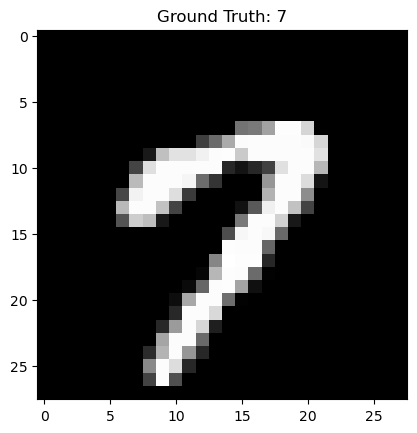

In [6]:
train_dataset[15]

目前我们已经成功的加载好了数据集。我们将正式开始构建深度学习的神经网络！

In [7]:
class Conv3x3(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Conv3x3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, bias=True), 
            nn.LeakyReLU(0.1, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.c1 = Conv3x3(1,8)
        self.c2 = Conv3x3(8,16)
        self.c3 = Conv3x3(16,4)
        self.pool = nn.MaxPool2d(2,2)
        self.rl1 = nn.Linear(100,10)
        

    def forward(self,x):
        x = self.c1(x) # 26x26x8
        x = self.c2(x) # 24x24x16
        x = self.pool(x) # 12x12x16
        x = self.c3(x)# 10x10x4
        x = self.pool(x) #5x5x4
        x = x.view(-1,100)
        x = self.rl1(x)
        return F.log_softmax(x,dim=1)

model = Net()
print(model)

Net(
  (c1): Conv3x3(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (c2): Conv3x3(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (c3): Conv3x3(
    (conv): Sequential(
      (0): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rl1): Linear(in_features=100, out_features=10, bias=True)
)


现在我们来初始化网络和优化器，正式开始训练！

In [8]:
optimizer = optim.SGD(model.parameters(),lr = lr, momentum = momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    model.train()    

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(model.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')


for epoch in n_epochs:
    train(epoch)
    

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309785
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.297111
Train Epoch: 1 [1200/60000 (2%)]	Loss: 2.283958
Train Epoch: 1 [1800/60000 (3%)]	Loss: 2.284429
Train Epoch: 1 [2400/60000 (4%)]	Loss: 2.263595
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.257394
Train Epoch: 1 [3600/60000 (6%)]	Loss: 2.239853
Train Epoch: 1 [4200/60000 (7%)]	Loss: 2.202046
Train Epoch: 1 [4800/60000 (8%)]	Loss: 2.096262
Train Epoch: 1 [5400/60000 (9%)]	Loss: 1.906199
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.635378
Train Epoch: 1 [6600/60000 (11%)]	Loss: 1.150966
Train Epoch: 1 [7200/60000 (12%)]	Loss: 0.816027
Train Epoch: 1 [7800/60000 (13%)]	Loss: 0.765922
Train Epoch: 1 [8400/60000 (14%)]	Loss: 0.977727
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.627917
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.769366


KeyboardInterrupt: 

Accuracy: 7738/10000 (77%)



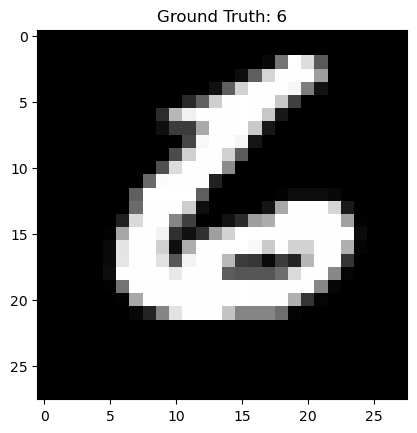

In [9]:
optimizer = optim.SGD(model.parameters(),lr = lr, momentum = momentum)
def test():
    model.load_state_dict(torch.load('./model.pth'))
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for data,target in test_loader:
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    print('Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
test()